In [1]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity
path_train = '../data/train_data.pkl'
path_val = '../data/val_data.pkl'

# 2 tensors of size 50000 x 3 x H x W
# denoise model with this data
noisy_imgs_1, noisy_imgs_2 = torch.load(path_train)
noisy_imgs_1 = noisy_imgs_1[0:50000].cpu().float()/256
noisy_imgs_2 = noisy_imgs_2[0:50000].cpu().float()/256

# mean = noisy_imgs_2.mean()
# std = noisy_imgs_2.std()
# noisy_imgs_1 = (noisy_imgs_1 - mean)/std
# noisy_imgs_2 = (noisy_imgs_2 - mean)/std
# # Track the progress with this data
noisy_imgs , clean_imgs = torch.load(path_val)
# print(noisy_imgs_1.size())
# print(noisy_imgs_2.size())
# print(noisy_imgs.size())

# print(clean_imgs.size())
torch.cuda.empty_cache()


In [2]:
noisy_imgs_2.size()

torch.Size([50000, 3, 32, 32])

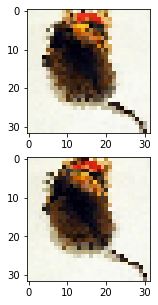

In [3]:
import matplotlib.pyplot as plt
import torchvision.transforms as T 
from PIL import Image

transform = T.ToPILImage()
plt.figure(figsize = [10, 5])
plt.subplot(2,1,1)
plt.imshow(transform((noisy_imgs_1[100])));
plt.subplot(2,1,2)
plt.imshow(transform(noisy_imgs_2[100]));

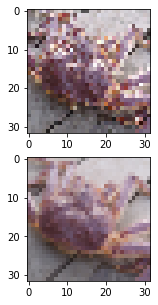

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize = [10, 5])
plt.subplot(2,1,1)
plt.imshow(transform(noisy_imgs[0]));
plt.subplot(2,1,2)
plt.imshow(transform(clean_imgs[0]));

The goal is to find a model $\phi$:
$$\phi(\hat{X}) = X$$
Quadratic loss: 
$$\hat{w} = argmin \frac{1}{N} \sum_{n=1}^N || x_n - \phi(x_n + \epsilon_n;w) || ^2$$
* $x_n$: data samples
* $\epsilon_n$ : gaussian noise

In [5]:
import torch
import torch.nn as nn


class UNet(nn.Module):
    """Custom U-Net architecture for Noise2Noise (see Appendix, Table 2)."""

    def __init__(self, in_channels=3, out_channels=3):
        """Initializes U-Net."""

        super(UNet, self).__init__()
        
        m = 10

        # Layers: enc_conv0, enc_conv1, pool1
        self._block1 = nn.Sequential(
            nn.Conv2d(in_channels, m, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(m, m, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))

        # Layers: enc_conv(i), pool(i); i=2..5
        self._block2 = nn.Sequential(
            nn.Conv2d(m, m, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))

        # Layers: enc_conv6, upsample5
        self._block3 = nn.Sequential(
            nn.Conv2d(m, m, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(m, m, 3, stride=2, padding=1, output_padding=1))
            #nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_conv5a, dec_conv5b, upsample4
        self._block4 = nn.Sequential(
            nn.Conv2d(m * 2, m * 2, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(m*2, m*2, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(m*2, m*2, 3, stride=2, padding=1, output_padding=1))
            #nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_deconv(i)a, dec_deconv(i)b, upsample(i-1); i=4..2
        self._block5 = nn.Sequential(
            nn.Conv2d(m*3, m*2, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(m*2, m*2, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(m*2, m*2, 3, stride=2, padding=1, output_padding=1))
            #nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_conv1a, dec_conv1b, dec_conv1c,
        self._block6 = nn.Sequential(
            nn.Conv2d(m*2 + in_channels, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1))

        # Initialize weights
        self._init_weights()


    def _init_weights(self):
        """Initializes weights using He et al. (2015)."""

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.zero_()


    def forward(self, x):
        """Through encoder, then decoder by adding U-skip connections. """

        # Encoder
        pool1 = self._block1(x)
        pool2 = self._block2(pool1)
        pool3 = self._block2(pool2)
        pool4 = self._block2(pool3)
        pool5 = self._block2(pool4)

        # Decoder
        upsample5 = self._block3(pool5)
        concat5 = torch.cat((upsample5, pool4), dim=1)
        upsample4 = self._block4(concat5)
        concat4 = torch.cat((upsample4, pool3), dim=1)
        upsample3 = self._block5(concat4)
        concat3 = torch.cat((upsample3, pool2), dim=1)
        upsample2 = self._block5(concat3)
        concat2 = torch.cat((upsample2, pool1), dim=1)
        upsample1 = self._block5(concat2)
        concat1 = torch.cat((upsample1, x), dim=1)

        # Final activation
        return self._block6(concat1)




In [6]:
import torch.nn.functional as F
import torch.nn as nn
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 48, 3)
        self.conv2 = nn.Conv2d(48, 48, 3)
        self.conv3 = nn.Conv2d(48, 48, 3)
        self.conv4 = nn.Conv2d(48, 8, 3)
        self.deconv1 = nn.ConvTranspose2d(8, 48, 3)
        self.deconv2 = nn.ConvTranspose2d(48, 48, 3)
        self.deconv3 = nn.ConvTranspose2d(48, 48, 3)
        self.deconv4 = nn.ConvTranspose2d(48, 3, 3)
        self.bn = nn.BatchNorm2d(48)
        self.sigmoid= nn.Sigmoid()
#         self.maxpool = F.max_pool2d(2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
    def forward(self, x):
        x1 = self.relu(self.bn(self.conv1(x)))
        x2 = self.relu(self.bn(self.conv2(x1)))
#         x3 = self.relu(self.bn(F.max_pool2d(x2, kernel_size = 2)))
        x5 = self.relu(self.bn(self.conv3(x3)))
#         x5 = self.relu(self.bn(F.max_pool2d(x5, kernel_size = 2)))
        x7 = self.relu(self.conv4(x5))
        x7 = self.relu(self.bn(self.deconv1(x7)))
#         x7 = self.relu(self.bn(self.upsample(x7)))
        x7 = self.relu(self.bn(self.deconv2(x7)))
#         x7 = self.relu(self.bn(self.upsample(x7)))
        x7 = self.relu(self.bn(self.deconv3(x7)))
        x7 = self.sigmoid(self.deconv4(x7))
        return x7
#         print(x7)
#             def forward(self, x):
#         x1 = self.dropout(self.relu(self.bn(self.conv1(x))))
#         x2 = self.dropout(self.relu(self.bn(self.conv2(x1))))
#         x3 = self.dropout(self.relu(self.bn(F.max_pool2d(x2, kernel_size = 2))))
#         x4 = self.dropout(self.relu(self.bn(self.conv3(x3))))
#         x5 = self.dropout(self.relu(self.bn(F.max_pool2d(x4, kernel_size = 2))))
#         x6 = self.dropout(self.relu(self.conv4(x5)))
#         x7 = self.dropout(self.relu(self.bn(self.deconv1(x6)) + x5))
#         x7 = self.dropout(self.relu(self.bn(self.upsample(x7))))
#         x7 = self.dropout(self.relu(self.bn(self.deconv2(x7)) + x3))
#         x7 = self.dropout(self.relu(self.bn(self.upsample(x7))))
#         x7 = self.dropout(self.relu(self.bn(self.deconv3(x7)) + x1))
#         x7 = self.dropout(self.relu(self.deconv4(x7)))
#         return x7

  0%|          | 0/20 [00:00<?, ?it/s]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


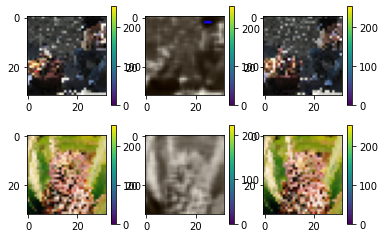

 15%|█▌        | 3/20 [00:29<02:43,  9.60s/it]

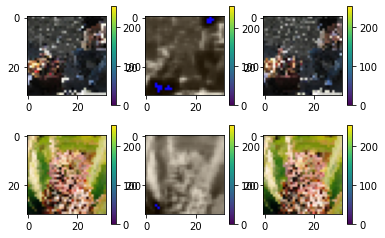

 30%|███       | 6/20 [00:58<02:14,  9.62s/it]

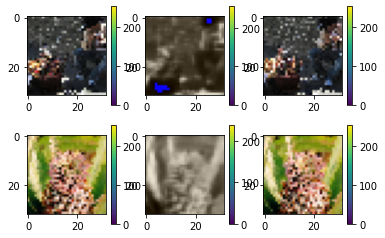

 45%|████▌     | 9/20 [01:27<01:45,  9.62s/it]

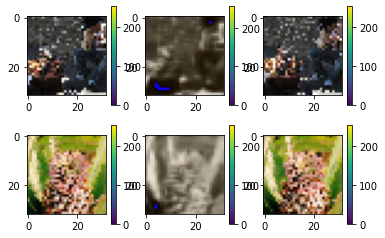

 60%|██████    | 12/20 [01:56<01:17,  9.64s/it]

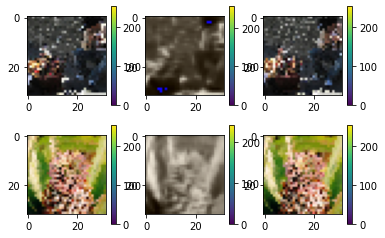

 75%|███████▌  | 15/20 [02:26<00:49,  9.84s/it]

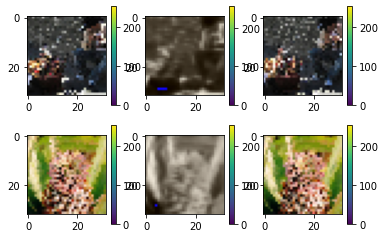

 90%|█████████ | 18/20 [02:55<00:19,  9.73s/it]

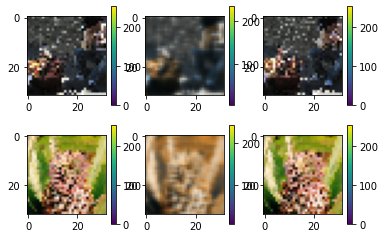

100%|██████████| 20/20 [03:15<00:00,  9.77s/it]


In [17]:
from torch import nn
from tqdm import tqdm
# device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = nn.Sequential(
    nn.Conv2d(3, 3, 3),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.BatchNorm2d(3),
    nn.Conv2d(3, 6, 3),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.BatchNorm2d(6),
    nn.Conv2d(6, 9, 3),
    nn.Dropout(p=0.2),
    nn.ReLU(),    
    nn.BatchNorm2d(9),
    nn.Conv2d(9, 4, 3),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm2d(4),
    nn.ConvTranspose2d(4, 9, 3),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm2d(9),
    nn.ConvTranspose2d(9, 6, 3),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm2d(6),
    nn.ConvTranspose2d(6, 3, 3),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm2d(3), 
    nn.ConvTranspose2d(3, 3, 3)
).to(device)

# model_paper = nn.Sequential(
    
# )
from PIL import Image
import torch 
import torchvision 
import torchvision.transforms as T 
from PIL import Image

transform = T.ToPILImage()
model = UNet().to(device)

batch_size, nb_epochs = 50, 20
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
mse = nn.MSELoss()

input = noisy_imgs_1.to(device).type(torch.float).split(batch_size)
target = noisy_imgs_2.to(device).type(torch.float).split(batch_size)

valid_inp = noisy_imgs.to(device).float()/256
valid_target = clean_imgs.to(device).float()/256

loss_tot = torch.zeros(nb_epochs)
loss_valid = torch.zeros(nb_epochs)
print(loss_tot)
for e in tqdm(range(nb_epochs)):
    model.train()
    for i in range(len(input)):
        output = model(input[i])
        loss = mse(output, target[i])
        loss_tot[e] += loss.item()    

        
        optimizer.zero_grad()
        loss.backward( retain_graph=True)
        optimizer.step()
    
    if torch.remainder(torch.tensor(e), 3)==0:
        plt.figure()
        im = 0
        im2 = 1
        plt.subplot(2, 3, 1)
        plt.imshow(transform(input[i][im]))
        plt.colorbar()
        plt.subplot(2, 3, 2)
        plt.imshow(transform(output[im]))
        plt.colorbar()
        plt.subplot(2, 3, 3)
        plt.imshow(transform(target[i][im]))
        plt.colorbar()
        plt.subplot(2, 3, 4)
        plt.imshow(transform(input[i][im2]))
        plt.colorbar()
        plt.subplot(2, 3, 5)
        plt.imshow(transform(output[im2]))
        plt.colorbar()
        plt.subplot(2, 3, 6)
        plt.imshow(transform(target[i][im2]))
        plt.colorbar()
        plt.show()


# print(output[0].size(), target[0].size())
    model.eval()
    output = model(valid_inp)
    loss_valid[e] = mse(output, valid_target).item()


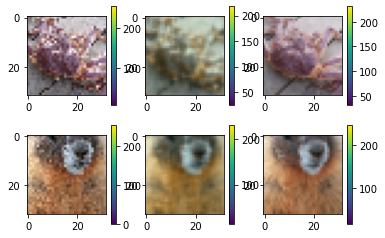

In [22]:
plt.figure()
im = 0
im2 = 1
plt.subplot(2, 3, 1)
plt.imshow(transform(valid_inp[im]))
plt.colorbar()
plt.subplot(2, 3, 2)
plt.imshow(transform(output[im]))
plt.colorbar()
plt.subplot(2, 3, 3)
plt.imshow(transform(valid_target[im]))
plt.colorbar()
plt.subplot(2, 3, 4)
plt.imshow(transform(valid_inp[im2]))
plt.colorbar()
plt.subplot(2, 3, 5)
plt.imshow(transform(output[im2]))
plt.colorbar()
plt.subplot(2, 3, 6)
plt.imshow(transform(valid_target[im2]))
plt.colorbar()
plt.show()

torch.Size([3, 32, 32]) torch.Size([50, 3, 32, 32])


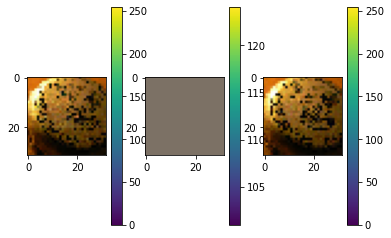

In [48]:
  
plt.figure()
im = 10
plt.subplot(1, 3, 1)
plt.imshow(transform(input[i][im]))
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(transform(output[im]))
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(transform(target[i][im]))
plt.colorbar()


print(output[0].size(), target[0].size())


In [50]:
loss_valid

tensor(0.0611, device='cuda:0', grad_fn=<MseLossBackward0>)

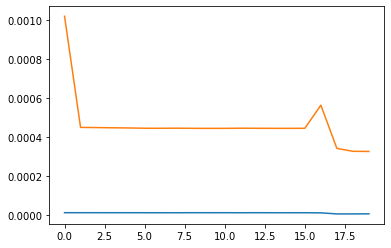

In [20]:
plt.plot(loss_valid/1000)
plt.plot(loss_tot/50000)

In [ ]:
mse = nn.MSELoss()

inp = input[i][0]
t = target[i][0]
out = output[0]
plt.imshow((inp - t).detach().cpu()[0]**2)
plt.colorbar()
plt.figure()
plt.imshow(transform(inp))

In [ ]:
plt.plot(loss_tot)
plt.plot(sum(mse(input[i], target[i]).item() for i in range(10))*torch.ones(len(loss_tot)))

In [ ]:
mse(input[i], target[i])

In [ ]:
plt.plot(loss_tot_with_dropout)
plt.plot(sum(mse(input[i], target[i]).item() for i in range(len(input)))*torch.ones(len(loss_tot_with_dropout)))

In [ ]:
plt.plot(loss_tot_with_batchnorm)

In [ ]:
plt.plot(loss_tot_with_batchnorm)

In [ ]:
plt.plot(loss_tot_with_batchnorm)

In [ ]:
plt.plot(loss_tot_with_batchnorm)

In [ ]:
plt.plot(loss_tot_with_batchnorm)

In [ ]:
plt.plot(loss_tot_with_batchnorm)